<a href="https://colab.research.google.com/github/talhaanwarch/Corona_Virus/blob/master/CT_scan/LRP_cross_validation_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-0c8bb8fa-defe-ac90-aa84-5f717967c3e6)


In [0]:
%%capture
!pip install efficientnet

In [0]:
%%capture
!pip install focal-loss

In [4]:
!wget https://raw.githubusercontent.com/talhaanwarch/keras-contrib/master/keras_contrib/callbacks/cyclical_learning_rate.py

--2020-05-06 23:53:23--  https://raw.githubusercontent.com/talhaanwarch/keras-contrib/master/keras_contrib/callbacks/cyclical_learning_rate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5976 (5.8K) [text/plain]
Saving to: ‘cyclical_learning_rate.py’

cyclical_learning_r 100%[===================>]   5.84K  --.-KB/s    in 0s      

2020-05-06 23:53:24 (84.2 MB/s) - ‘cyclical_learning_rate.py’ saved [5976/5976]



### CLone github repo, to dowlonad data

In [5]:
!git clone https://github.com/UCSD-AI4H/COVID-CT.git

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5443, done.
remote: Total 5443 (delta 0), reused 0 (delta 0), pack-reused 5443
Receiving objects: 100% (5443/5443), 1.09 GiB | 43.26 MiB/s, done.
Resolving deltas: 100% (355/355), done.
Checking out files: 100% (1048/1048), done.


### Extract data in one format

In [0]:
%%capture
!unzip /content/COVID-CT/Images-processed/CT_COVID.zip
!unzip /content/COVID-CT/Images-processed/CT_NonCOVID.zip

In [0]:
!mkdir images
!cp -r /content/CT_COVID/* images
!cp -r /content/CT_NonCOVID/* images


###read meta files

In [0]:
import pandas as pd
import os

In [9]:
covid=os.listdir('/content/CT_COVID')
cov=list(zip(covid,['covid']*(len(covid))))
covid_df = pd.DataFrame(cov,columns=['file','label']) 
covid_df.head()

,file,label
0,PIIS0140673620303603%2.png,covid
1,2020.03.09.20033118-p20-93%3.png,covid
2,Talaromyces-marneffei-infection-relapse-presen...,covid
3,2020.02.27.20027557-p25-137%3.png,covid
4,2020.02.23.20026856-p17-115%2.png,covid


In [10]:
noncovid=os.listdir('/content/CT_NonCOVID')
noncov=list(zip(noncovid,['noncovid']*(len(noncovid))))
noncovid_df = pd.DataFrame(noncov,columns=['file','label']) 
noncovid_df.head()

,file,label
0,19%0.jpg,noncovid
1,12.jpg,noncovid
2,1100.png,noncovid
3,1923.png,noncovid
4,890.png,noncovid


In [11]:
dataframe=pd.concat([covid_df,noncovid_df])
dataframe.head()

,file,label
0,PIIS0140673620303603%2.png,covid
1,2020.03.09.20033118-p20-93%3.png,covid
2,Talaromyces-marneffei-infection-relapse-presen...,covid
3,2020.02.27.20027557-p25-137%3.png,covid
4,2020.02.23.20026856-p17-115%2.png,covid


In [12]:
df = pd.get_dummies(dataframe['label'])
df = pd.concat([dataframe, df], axis=1)
df=df.sample(frac=1)
df.head()


,file,label,covid,noncovid
162,84%2.jpg,noncovid,0,1
238,2020.02.24.20027052-p8-73%3.png,covid,1,0
327,5%5.jpg,noncovid,0,1
241,658.png,noncovid,0,1
40,2020.03.18.20038125-p16-56-1.png,covid,1,0


#### TEST DATA

In [13]:
covid_test=pd.read_csv('/content/COVID-CT/Data-split/COVID/testCT_COVID.txt',header=None,squeeze=True).tolist()
noncovid_test=pd.read_csv('/content/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',header=None,squeeze=True).tolist()
test=covid_test+noncovid_test
len(test)

203

In [14]:
len(test),len(covid_test),len(noncovid_test)

(203, 98, 105)

In [0]:
test_df=df[df['file'].isin(test)]
train_df=df[~df['file'].isin(test)]

In [16]:
len(df),len(train_df),len(test_df)

(746, 543, 203)

### Data generator

In [0]:
from keras_preprocessing.image import ImageDataGenerator
data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    #rotation_range=360,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #zoom_range=.2,
    rescale=1/255,
    fill_mode='nearest',
    #shear_range=0.2,
    #brightness_range=[0.2, 2.0],
    )

In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

#Train model

In [0]:
img_shape=300
batch_size=16

In [0]:
from cyclical_learning_rate import CyclicLR


In [21]:
from sklearn.model_selection import KFold
import gc
from focal_loss import BinaryFocalLoss
from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score
classification_reports=[]
kf = KFold(n_splits=5)
history=[]
accuracy=[]
f1_scores=[]
auc=[]
y_pred=[]
fold=0
for train_index, test_index in kf.split(train_df):
  train=train_df.iloc[train_index,:]
  val=train_df.iloc[test_index,:]
  print('-----------fold {}--------------'.format(fold))
  train_generator=data_gen.flow_from_dataframe(train,directory='images',
                                                      target_size=(img_shape,img_shape),
                                                      x_col="file",
                                                      y_col=['covid','noncovid'],
                                                      class_mode='raw',
                                                      shuffle=True,
                                                      batch_size=batch_size)

  val_generator=data_gen.flow_from_dataframe(val,directory='images',
                                                        target_size=(img_shape,img_shape),
                                                        x_col="file",
                                                        y_col=['covid','noncovid'],
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        batch_size=batch_size)
  
  test_generator=data_gen.flow_from_dataframe(test_df,directory='images',
                                                      target_size=(img_shape,img_shape),
                                                      x_col="file",
                                                      y_col=['covid','noncovid'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=batch_size)
  #train_generator.next()[0].shape,train_generator.next()[1].shape
  import efficientnet.tfkeras as efn
  model =efn.EfficientNetB3(weights ='noisy-student', include_top=False, input_shape = (img_shape,img_shape,3))
    
  x = model.output
  x = GlobalAveragePooling2D()(x)
  #x = Dropout(0.3)(x)
  #x = Dense(128, activation="relu")(x)
  #x = Dropout(0.3)(x)
  #x = Dense(64, activation="relu")(x)
  predictions = Dense(2, activation="softmax")(x)
  model = Model(inputs=model.input, outputs=predictions)


  model.compile(optimizer=Adam(0.001), loss=BinaryFocalLoss(gamma=2), metrics=['accuracy'])

  results = model.fit(train_generator,epochs=25,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[
                                         ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.000001),
                                         #CyclicLR(base_lr=1e-5,max_lr=1e-3,step_size=(6*train_generator.n/batch_size))
                                         ])
  #model.load_weights('model_{}.hdf5'.format(fold))
  test_generator.reset()
  y_pred.append(model.predict(test_generator,steps=test_generator.n/batch_size,verbose=1))
  history.append(results)

  
  fold+=1
  del model
  tf.keras.backend.clear_session()
  gc.collect()

-----------fold 0--------------
Found 434 validated image filenames.
Found 109 validated image filenames.
Found 203 validated image filenames.
43933696/43933088 [==============================] - 2s 0us/step
Epoch 1/25
28/27 [==============================] - 13s 464ms/step - loss: 0.2092 - accuracy: 0.6912 - val_loss: 0.2143 - val_accuracy: 0.6239 - lr: 0.0010
Epoch 2/25
28/27 [==============================] - 10s 372ms/step - loss: 0.1081 - accuracy: 0.8295 - val_loss: 0.1579 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 3/25
28/27 [==============================] - 10s 373ms/step - loss: 0.1199 - accuracy: 0.8134 - val_loss: 0.1665 - val_accuracy: 0.6606 - lr: 0.0010
Epoch 4/25
28/27 [==============================] - 10s 369ms/step - loss: 0.0708 - accuracy: 0.8779 - val_loss: 0.1503 - val_accuracy: 0.8165 - lr: 0.0010
Epoch 5/25
28/27 [==============================] - 11s 376ms/step - loss: 0.0525 - accuracy: 0.9355 - val_loss: 0.0862 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 6/25
2

In [22]:
import numpy as np
y_mean=np.mean(y_pred,axis=0)
y_true=test_df.iloc[:,2::]
y_true.shape,y_mean.shape

((203, 2), (203, 2))

In [23]:
y_mean=np.argmax(y_mean,axis=1).ravel()
y_true=np.argmax(y_true.values,axis=1).ravel()

y_true.shape,y_mean.shape

((203,), (203,))

In [24]:

print(classification_report(y_true, y_mean,target_names=['covid','noncovid']))#
print('accuracy',np.round(accuracy_score(y_true,y_mean),2))
print('f1 score is ',np.round(f1_score(y_true,y_mean,average='macro'),2))
print('auc',np.round(roc_auc_score(y_true,y_mean),2))

              precision    recall  f1-score   support

       covid       0.89      0.78      0.83        98
    noncovid       0.81      0.91      0.86       105

    accuracy                           0.85       203
   macro avg       0.85      0.84      0.85       203
weighted avg       0.85      0.85      0.85       203

accuracy 0.85
f1 score is  0.85
auc 0.84


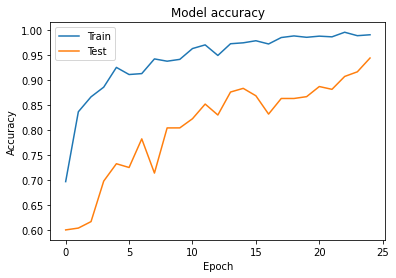

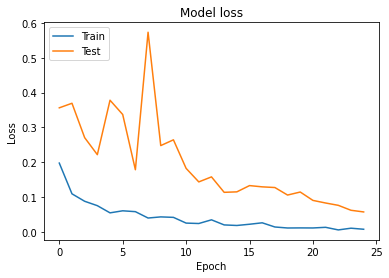

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(np.mean([[j for j in x.history['accuracy']] for x in history ],axis=0))
plt.plot(np.mean([[j for j in x.history['val_accuracy']] for x in history ],axis=0))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(np.mean([[j for j in x.history['loss']] for x in history ],axis=0))
plt.plot(np.mean([[j for j in x.history['val_loss']] for x in history ],axis=0))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

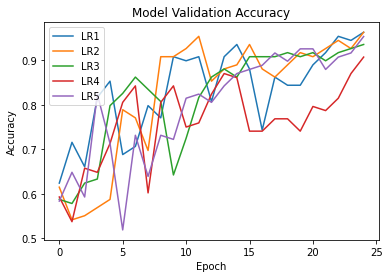

In [27]:
# Plot training & validation loss values
for i in range(5):
  plt.plot(history[i].history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LR1','LR2','LR3','LR4','LR5' ], loc='upper left')
plt.show()

In [0]:
history[0].history.keys()

In [0]:
# # Plot training & validation loss values
# #plt.plot([i.history['lr'] for i in history])
# plt.title('Model LR')
# plt.ylabel('LR')
# plt.xlabel('Epoch')
# plt.legend(['LR1','LR2','LR3','LR4','LR5' ], loc='upper left')
# plt.show()

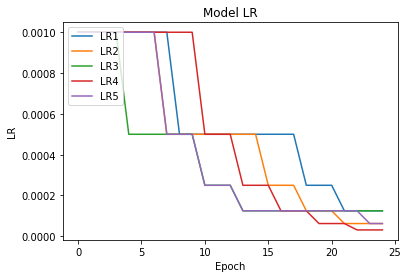

In [26]:
# Plot training & validation loss values
for i in range(5):
  plt.plot(history[i].history['lr'])
plt.title('Model LR')
plt.ylabel('LR')
plt.xlabel('Epoch')
plt.legend(['LR1','LR2','LR3','LR4','LR5' ], loc='upper left')
plt.show()